In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

## Checkerboard dataset (2D)

We define a **two-dimensional synthetic checkerboard dataset**, which is commonly used in the paper

The distribution is constructed as a **uniform mixture over alternating cells** of a regular grid.  
Specifically, we select grid cells \((i, j)\) such that \((i + j)\) is even, and then sample uniformly within each selected cell. This implementation avoids rejection sampling and guarantees a well-defined uniform distribution.

The figure below visualizes the **target distribution**. It serves as a reference for assessing the quality of generated samples and for comparing different training objectives and numbers of sampling steps.


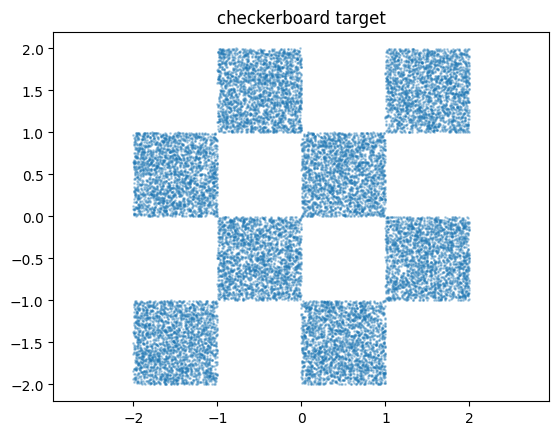

In [2]:
def sample_checkerboard(n, n_cells=4, cell_size=1.0, jitter=0.0, device="cpu"):
    # List all valid (i,j) with (i+j)%2==0
    coords = []
    for i in range(n_cells):
        for j in range(n_cells):
            if (i + j) % 2 == 0:
                coords.append((i, j))
    coords = torch.tensor(coords, device=device, dtype=torch.float32)

    # Sample cells uniformly
    idx = torch.randint(0, coords.shape[0], (n,), device=device)
    cell_ij = coords[idx]

    # Uniform offset inside each cell
    u = torch.rand(n, 2, device=device)
    x = (cell_ij + u) * cell_size

    # Center around 0
    x = x - (n_cells * cell_size) / 2.0

    if jitter > 0:
        x = x + jitter * torch.randn_like(x)

    return x

x_tgt = sample_checkerboard(n=20000)

plt.figure()
plt.scatter(x_tgt[:,0], x_tgt[:,1], s=1, alpha=0.3)
plt.title("checkerboard target")
plt.axis("equal")
plt.show()

## Base distribution

We define the **base distribution** \(x_0\) as a standard two-dimensional Gaussian, which serves as the starting point for the generative process.

The scatter plot below illustrates samples drawn from the base Gaussian. In the following sections, we will learn a transport map that pushes this distribution toward the checkerboard target distribution.


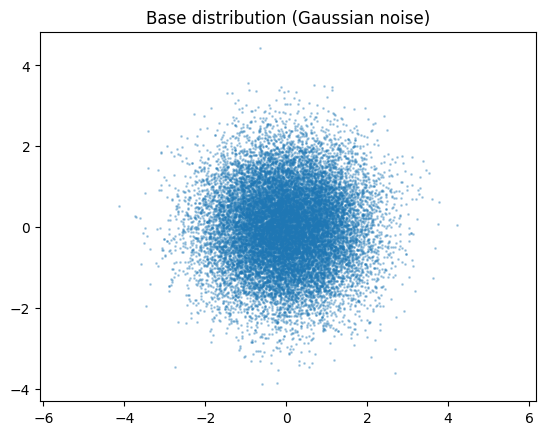

In [3]:
def sample_base_gaussian(n, device="cpu"):
    return torch.randn(n, 2, device=device)

x0 = sample_base_gaussian(n=20000)

plt.figure()
plt.scatter(x0[:,0], x0[:,1], s=1, alpha=0.3)
plt.title("Base distribution (Gaussian noise)")
plt.axis("equal")
plt.show()

## Linear interpolation between base and target samples

We introduce a **linear interpolant** between the base samples \(x_0\) and the target samples \(x_1\),

This interpolant defines a simple path that continuously connects the base distribution to the target distribution. Although it does not correspond to the true optimal transport path, it provides a convenient and widely used reference trajectory for training transport-based models.

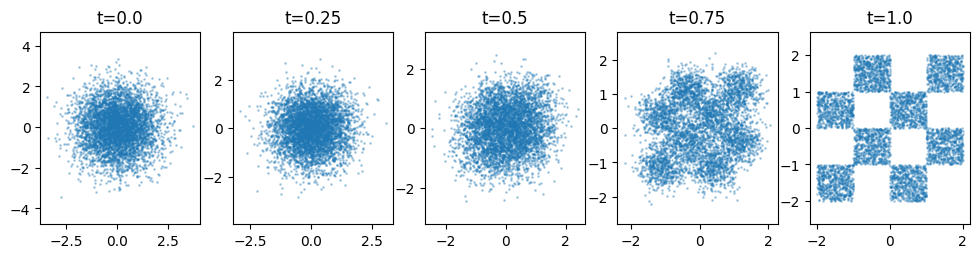

In [4]:
def interp_linear(x0, x1, t):
    # alpha=1-t, beta=t
    return (1-t)*x0 + t*x1

n = 5000
x0_s = x0[:n]
x1_s = x_tgt[:n]

ts = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(12, 2.5))
for k,t in enumerate(ts):
    xt = interp_linear(x0_s, x1_s, t)
    ax = plt.subplot(1, len(ts), k+1)
    ax.scatter(xt[:,0], xt[:,1], s=1, alpha=0.3)
    ax.set_title(f"t={t}")
    ax.axis("equal")
plt.show()


## Velocity field parameterization

We model the transport dynamics using a neural network that predicts a **velocity field** in two dimensions.  
The network takes as input the current position along with two time variables and outputs a displacement direction.

Conditioning on both time variables allows the model to represent interactions between different points along the interpolation path, which is required by self-distillation objectives such as LSD and PSD.


In [5]:
class VNet(nn.Module):
    def __init__(self, hidden=256, depth=4):
        super().__init__()
        layers = []
        in_dim = 4
        for k in range(depth):
            layers.append(nn.Linear(in_dim if k==0 else hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x, s, t):
        # x: (B,2), s,t: (B,1) or (B,)
        if s.dim() == 1: s = s[:, None]
        if t.dim() == 1: t = t[:, None]
        inp = torch.cat([x, s, t], dim=1)
        return self.net(inp)


## Interpolation and intermediate flow utilities

This cell defines a few helper functions used throughout training and sampling.

- `interpolant(...)` builds the intermediate points along the linear path between the Gaussian base samples and the checkerboard target samples, and also returns the corresponding “reference direction” along that path.
- `X_hat(...)` defines a single transport update that moves points from time `s` to time `t` using the velocity predicted by the network.
- `dX_dt_hat(...)` computes how the transport update changes with respect to time.


In [6]:
def interpolant(x0, x1, t):
    if t.dim() == 1: t = t[:, None]
    It = (1 - t) * x0 + t * x1
    dIt = (x1 - x0)
    return It, dIt

def X_hat(vnet, x, s, t):
    return x + (t - s)[:, None] * vnet(x, s, t)

def dX_dt_hat(vnet, x, s, t):
    B = x.shape[0]
    t_req = t.clone().detach().requires_grad_(True)

    def f(t_in):
        return X_hat(vnet, x, s, t_in)

    v = torch.ones_like(t_req)
    y, jvp = torch.autograd.functional.jvp(f, (t_req,), (v,), create_graph=True)
    return jvp


## LSD training loop

This section implements the training procedure for LSD.

- `sample_upper_triangle(...)` draws random time pairs `(s, t)` with `s < t`, which are used to train the model on off-diagonal time relationships.
- The training loop mixes two types of batches:
  - **Diagonal samples** (`s = t`): the model learns the basic velocity along the interpolation path between base and target samples.
  - **Off-diagonal samples** (`s < t`): the LSD objective encourages consistency of the learned transport dynamics across time by matching a time-derivative signal to a “teacher” prediction.

In [7]:
def sample_upper_triangle(B, device):
    t = torch.rand(B, device=device)
    s = torch.rand(B, device=device) * t
    return s, t

def train_lsd(vnet, steps=50_000, batch=2048, eta=0.75, lr=2e-4, n_cells=4, device="cpu"):
    opt = torch.optim.AdamW(vnet.parameters(), lr=lr, weight_decay=1e-4)

    for it in range(1, steps+1):
        vnet.train()
        Md = int(batch * eta)
        Mo = batch - Md

        # diagonale: s=t=u ~ U[0,1]
        x1 = sample_checkerboard(Md, n_cells=n_cells, device=device)
        x0 = sample_base_gaussian(Md, device=device)
        t = torch.rand(Md, device=device)
        It, dIt = interpolant(x0, x1, t)
        v_diag = vnet(It, t, t)
        loss_b = F.mse_loss(v_diag, dIt)

        # off-diagonal: LSD
        x1o = sample_checkerboard(Mo, n_cells=n_cells, device=device)
        x0o = sample_base_gaussian(Mo, device=device)
        s, t2 = sample_upper_triangle(Mo, device=device)
        Is, _ = interpolant(x0o, x1o, s)

        Xst = X_hat(vnet, Is, s, t2)
        dXdt = dX_dt_hat(vnet, Is, s, t2)

        with torch.no_grad():
            teacher = vnet(Xst, t2, t2)  # sg(.) via no_grad
        loss_d = F.mse_loss(dXdt, teacher)

        loss = loss_b + loss_d

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if it % 1000 == 0:
            print(f"iter {it:6d} | Lb {loss_b.item():.4f} | LD {loss_d.item():.4f} | L {loss.item():.4f}")

    return vnet


## Sampling and visualization

After training, we generate samples by **iteratively applying the learned transport map** starting from the Gaussian base distribution.

- `sample_steps(...)` composes the learned update multiple times along a uniform time grid. The number of steps controls the discretization of the transport: using more steps results in a finer approximation of the continuous dynamics.
- `plot_checker_samples(...)` visualizes the generated samples as a scatter plot, allowing direct qualitative comparison with the target checkerboard distribution.


In [8]:
@torch.no_grad()
def sample_steps(vnet, n_samples=50_000, n_steps=1, device="cpu"):
    vnet.eval()
    x = sample_base_gaussian(n_samples, device=device)
    ts = torch.linspace(0, 1, n_steps+1, device=device)
    for i in range(n_steps):
        s = torch.full((n_samples,), ts[i].item(), device=device)
        t = torch.full((n_samples,), ts[i+1].item(), device=device)
        x = X_hat(vnet, x, s, t)
    return x


In [9]:
def plot_checker_samples(samples, title="", lim=2.5, s=1):
    x = samples.detach().cpu()
    plt.figure(figsize=(4,4))
    plt.scatter(x[:,0], x[:,1], s=s, alpha=0.5)
    plt.xlim(-lim, lim); plt.ylim(-lim, lim)
    plt.gca().set_aspect("equal", "box")
    plt.title(title)
    plt.show()


## Training and multi-step generation with LSD

We now train the velocity network using the LSD objective and evaluate the resulting model by generating samples with different numbers of transport steps.

First, the network is initialized and trained on the checkerboard dataset. The training procedure combines diagonal and off-diagonal supervision, as described above, to learn a stable time-dependent transport dynamics.

After training, we generate samples starting from the Gaussian base distribution and apply the learned transport map using different numbers of steps (1, 2, 4, and 8). This allows us to analyze how the quality of the generated samples depends on the discretization of the transport process.


In [10]:
vnet = VNet(hidden=256, depth=4).to(device)

vnet = train_lsd(
    vnet,
    steps=20_000,
    batch=2048,
    eta=0.75,
    lr=2e-4,
    n_cells=4,
    device=device
)

print("Training finished.")

iter   1000 | Lb 1.6712 | LD 0.0093 | L 1.6804
iter   2000 | Lb 1.7856 | LD 0.0080 | L 1.7937
iter   3000 | Lb 1.8092 | LD 0.0042 | L 1.8134
iter   4000 | Lb 1.7884 | LD 0.0039 | L 1.7923
iter   5000 | Lb 1.8181 | LD 0.0070 | L 1.8251
iter   6000 | Lb 1.7004 | LD 0.0066 | L 1.7070
iter   7000 | Lb 1.7685 | LD 0.0067 | L 1.7752
iter   8000 | Lb 1.6975 | LD 0.0095 | L 1.7069
iter   9000 | Lb 1.7117 | LD 0.0069 | L 1.7186
iter  10000 | Lb 1.6120 | LD 0.0079 | L 1.6199
iter  11000 | Lb 1.6868 | LD 0.0051 | L 1.6920
iter  12000 | Lb 1.7238 | LD 0.0087 | L 1.7324
iter  13000 | Lb 1.7072 | LD 0.0080 | L 1.7152
iter  14000 | Lb 1.7912 | LD 0.0057 | L 1.7970
iter  15000 | Lb 1.7017 | LD 0.0077 | L 1.7094
iter  16000 | Lb 1.7358 | LD 0.0089 | L 1.7447
iter  17000 | Lb 1.7339 | LD 0.0089 | L 1.7428
iter  18000 | Lb 1.7158 | LD 0.0105 | L 1.7263
iter  19000 | Lb 1.7907 | LD 0.0213 | L 1.8120
iter  20000 | Lb 1.7846 | LD 0.0069 | L 1.7915
Training finished.


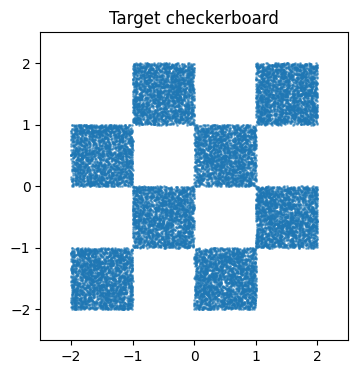

In [11]:
x_true = sample_checkerboard(n=20_000, n_cells=4, device=device)
plot_checker_samples(x_true, title="Target checkerboard", lim=2.5, s=1)


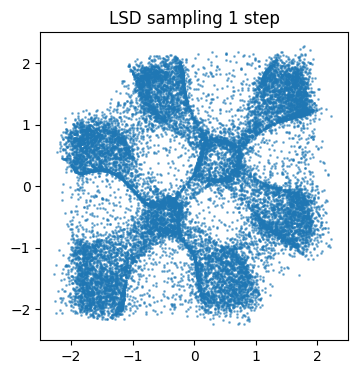

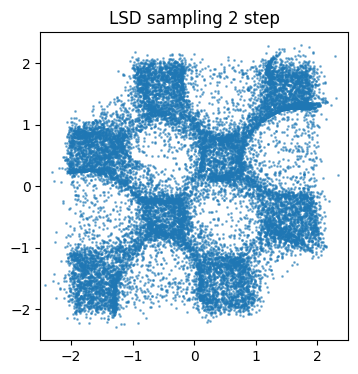

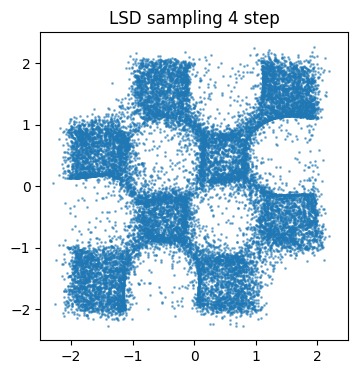

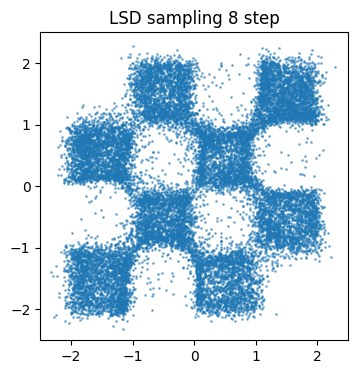

In [12]:
for N in [1, 2, 4, 8]:
    x_gen = sample_steps(vnet, n_samples=20_000, n_steps=N, device=device)
    plot_checker_samples(x_gen, title=f"LSD sampling {N} step", lim=2.5,s=1)


## PSD objective and training loop

This section implements PSD.

- `train_psd(...)` follows the same overall structure as `train_lsd(...)`:
  - a **diagonal term** trains the model on the basic interpolation dynamics,
  - an **off-diagonal term** applies the PSD consistency constraint.

This makes the comparison between LSD and PSD controlled: both methods use the same architecture, data, optimizer, and diagonal supervision, and differ only in how off-diagonal consistency is enforced.


In [13]:
def psd_midpoint_loss(vnet, Is, s, t):
    """
    PSD midpoint: enforce semigroup consistency using u=(s+t)/2.
    Loss: || X_{s,t}(Is) - sg( X_{u,t}( X_{s,u}(Is) ) ) ||^2
    """
    u = 0.5 * (s + t)
    Xsu = X_hat(vnet, Is, s, u)
    Xut = X_hat(vnet, Xsu, u, t)
    Xst = X_hat(vnet, Is, s, t)

    with torch.no_grad():
        teacher = Xut
    return F.mse_loss(Xst, teacher)

def train_psd(vnet, steps=50_000, batch=2048, eta=0.75, lr=2e-4, n_cells=4, device="cpu"):
    """
    Same diagonal training as LSD (Lb), but off-diagonal uses PSD midpoint loss.
    """
    opt = torch.optim.AdamW(vnet.parameters(), lr=lr, weight_decay=1e-4)

    for it in range(1, steps + 1):
        Md = int(batch * eta)
        Mo = batch - Md

        # diagonal loss (Lb)
        x1 = sample_checkerboard(Md, n_cells=n_cells, device=device)
        x0 = sample_base_gaussian(Md, device=device)
        t = torch.rand(Md, device=device)
        It, dIt = interpolant(x0, x1, t)
        loss_b = F.mse_loss(vnet(It, t, t), dIt)

        # off-diagonal PSD loss
        x1o = sample_checkerboard(Mo, n_cells=n_cells, device=device)
        x0o = sample_base_gaussian(Mo, device=device)
        s, t2 = sample_upper_triangle(Mo, device=device)
        Is, _ = interpolant(x0o, x1o, s)

        loss_d = psd_midpoint_loss(vnet, Is, s, t2)

        loss = loss_b + loss_d

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if it % 1000 == 0:
            print(f"iter {it:6d} | Lb {loss_b.item():.4f} | LD {loss_d.item():.4f} | L {loss.item():.4f}")

    return vnet

## Training and multi-step generation with PSD

We now train the velocity network using the PSD objective and evaluate the resulting model by generating samples with different numbers of transport steps.

First, the network is initialized and trained on the checkerboard dataset. The training procedure combines diagonal and off-diagonal supervision, as described above, to learn a stable time-dependent transport dynamics.

After training, we generate samples starting from the Gaussian base distribution and apply the learned transport map using different numbers of steps (1, 2, 4, and 8). This allows us to analyze how the quality of the generated samples depends on the discretization of the transport process.

In [14]:
vnet_psd = VNet(hidden=256, depth=4).to(device)

vnet_psd = train_psd(
    vnet_psd,
    steps=20_000,
    batch=2048,
    eta=0.75,
    lr=2e-4,
    n_cells=4,
    device=device,
)


iter   1000 | Lb 1.7674 | LD 0.0011 | L 1.7686
iter   2000 | Lb 1.7525 | LD 0.0007 | L 1.7532
iter   3000 | Lb 1.8118 | LD 0.0016 | L 1.8134
iter   4000 | Lb 1.6639 | LD 0.0008 | L 1.6647
iter   5000 | Lb 1.7374 | LD 0.0009 | L 1.7383
iter   6000 | Lb 1.7072 | LD 0.0007 | L 1.7079
iter   7000 | Lb 1.7687 | LD 0.0003 | L 1.7690
iter   8000 | Lb 1.7394 | LD 0.0005 | L 1.7399
iter   9000 | Lb 1.6493 | LD 0.0004 | L 1.6496
iter  10000 | Lb 1.6814 | LD 0.0006 | L 1.6820
iter  11000 | Lb 1.7643 | LD 0.0008 | L 1.7651
iter  12000 | Lb 1.6757 | LD 0.0007 | L 1.6763
iter  13000 | Lb 1.6472 | LD 0.0007 | L 1.6479
iter  14000 | Lb 1.7095 | LD 0.0008 | L 1.7103
iter  15000 | Lb 1.7093 | LD 0.0008 | L 1.7101
iter  16000 | Lb 1.7509 | LD 0.0009 | L 1.7518
iter  17000 | Lb 1.7489 | LD 0.0009 | L 1.7498
iter  18000 | Lb 1.6695 | LD 0.0008 | L 1.6703
iter  19000 | Lb 1.7538 | LD 0.0007 | L 1.7546
iter  20000 | Lb 1.7175 | LD 0.0006 | L 1.7181


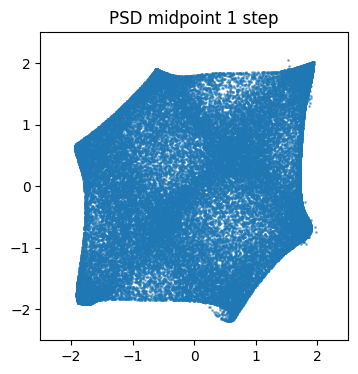

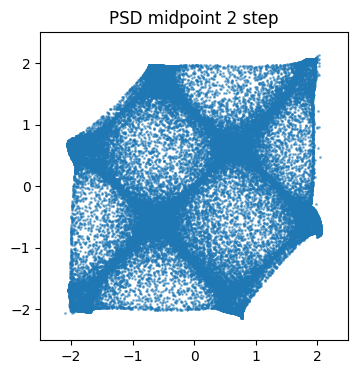

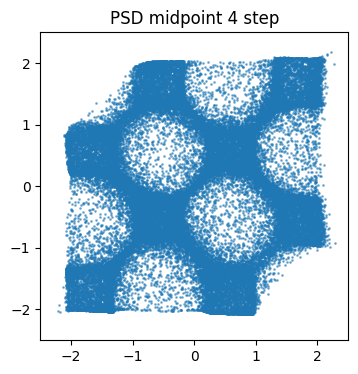

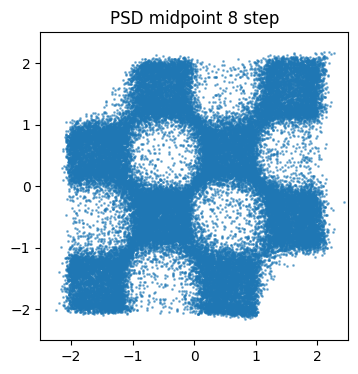

In [15]:
for N in [1, 2, 4, 8]:
    x_psd = sample_steps(vnet_psd, n_samples=50_000, n_steps=N, device=device)
    plot_checker_samples(x_psd, title=f"PSD midpoint {N} step", lim=2.5, s=1)


## Visual comparison: LSD vs PSD

We compare LSD and PSD by generating samples with different numbers of transport steps (1, 2, 4, and 8).

The first row shows samples generated with LSD, while the second row shows samples generated with PSD under identical conditions. This side-by-side visualization highlights how each method behaves.

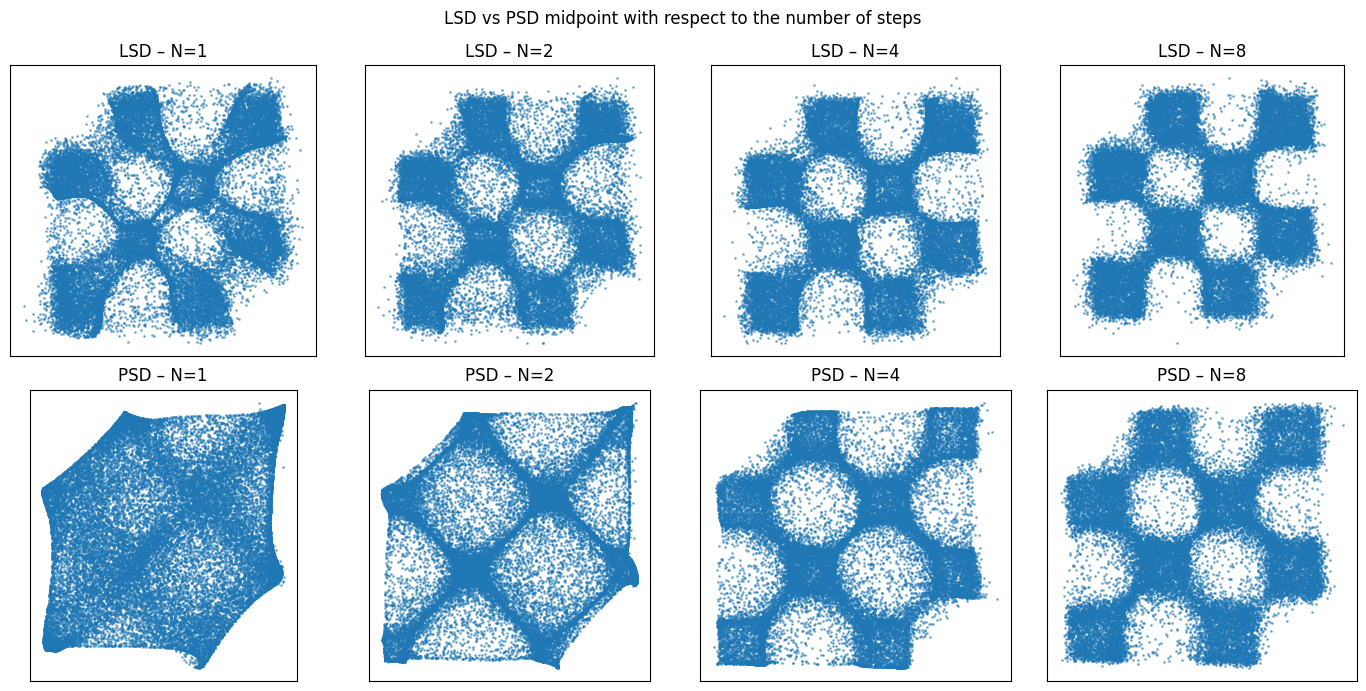

In [17]:
Ns = [1, 2, 4, 8]

plt.figure(figsize=(14, 7))

for j, N in enumerate(Ns):
    # LSD
    x_lsd = sample_steps(vnet, n_samples=30_000, n_steps=N, device=device).cpu()
    ax = plt.subplot(2, 4, 1 + j)
    ax.scatter(x_lsd[:, 0], x_lsd[:, 1], s=1, alpha=0.5)
    ax.set_title(f"LSD – N={N}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect("equal", "box")

    # PSD
    x_psd = sample_steps(vnet_psd, n_samples=30_000, n_steps=N, device=device).cpu()
    ax = plt.subplot(2, 4, 5 + j)
    ax.scatter(x_psd[:, 0], x_psd[:, 1], s=1, alpha=0.5)
    ax.set_title(f"PSD – N={N}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect("equal", "box")

plt.suptitle("LSD vs PSD midpoint with respect to the number of steps")
plt.tight_layout()
plt.show()


## KL divergence

In addition to visual inspection, we provide a quantitative comparison using the Kullback–Leibler (KL) divergence between the generated distribution and the target checkerboard distribution.

This metric allows us to quantify how sample quality improves as the number of transport steps increases, and to confirm that LSD achieves lower divergence than PSD at small step counts.


In [20]:
def kl_histogram_2d(x_true, x_gen, bins=50, lim=2.5, eps=1e-8):
    """
    Estimate KL(p || q) using 2D histograms on a fixed grid.
    """
    # Convert to numpy
    x_true = x_true.cpu().numpy()
    x_gen  = x_gen.cpu().numpy()

    # Common bin edges
    edges = np.linspace(-lim, lim, bins + 1)

    # Histograms
    p_hist, _, _ = np.histogram2d(
        x_true[:, 0], x_true[:, 1],
        bins=[edges, edges]
    )
    q_hist, _, _ = np.histogram2d(
        x_gen[:, 0], x_gen[:, 1],
        bins=[edges, edges]
    )

    # Normalize to probabilities
    p = p_hist / np.sum(p_hist)
    q = q_hist / np.sum(q_hist)

    # Avoid log(0)
    p = p + eps
    q = q + eps

    # KL(p || q)
    kl = np.sum(p * np.log(p / q))
    return float(kl)


In [21]:
x_true = sample_checkerboard(n=100_000, n_cells=4, device=device)

Ns = [1, 2, 4, 8, 16]

kl_lsd = {}
kl_psd = {}

for N in Ns:
    x_lsd = sample_steps(vnet, n_samples=100_000, n_steps=N, device=device)
    x_psd = sample_steps(vnet_psd, n_samples=100_000, n_steps=N, device=device)

    kl_lsd[N] = kl_histogram_2d(x_true, x_lsd, bins=60)
    kl_psd[N] = kl_histogram_2d(x_true, x_psd, bins=60)

    print(f"N={N:2d} | KL(LSD)={kl_lsd[N]:.4f} | KL(PSD)={kl_psd[N]:.4f}")


N= 1 | KL(LSD)=0.4050 | KL(PSD)=1.4963
N= 2 | KL(LSD)=0.3688 | KL(PSD)=0.8452
N= 4 | KL(LSD)=0.2798 | KL(PSD)=0.4717
N= 8 | KL(LSD)=0.2074 | KL(PSD)=0.2652
N=16 | KL(LSD)=0.1940 | KL(PSD)=0.2068
